In [14]:
from rdkit import Chem
from rdkit.Chem import Atom, BondType
from rdkit.Chem.Draw import IPythonConsole

import numpy as np
import pandas as pd

In [2]:
def amat_entry(amat,r,c,val):
    """
    changes the (r,c) and (c,r) values of matrix "amat" to "val"
    """
    amat[r-1][c-1] = amat[c-1][r-1]= val
    return

In [3]:
def amat_edit(amat,r,c,delta):
    """
    changes the (r,c) and (c,r) values of matrix "amat" to "val"
    """
    amat[r-1][c-1] += delta
    if r != c:
        amat[c-1][r-1] += delta
    return

In [4]:
def molFromAdjMat(atoms, amat):
    """Creates a mol object from an adjacency matrix.
    Inputs:
    atoms: list of atomic numbers of atoms, by row
    amat: adjacency matrix. Has to have same length as atoms (obviously)
    Output: mol object
    Might need to add a try clause for sanitize"""
    
    m = Chem.RWMol()
    # add in the separate atoms
    for a in atoms: m.AddAtom(Atom(a))
    side_len = len(amat)    
    for r in range(side_len):
        for c in range(r+1,side_len):
            bond_order = amat[r][c]
            if bond_order > 0:
                if bond_order == 1: m.AddBond(r,c,BondType.SINGLE)
                if bond_order == 2: m.AddBond(r,c,BondType.DOUBLE)
                if bond_order == 3: m.AddBond(r,c,BondType.TRIPLE)

    Chem.SanitizeMol(m)
    return m

In [5]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx()+1)
    return mol

In [6]:
def make_changelogs(data_file_path):
    data = pd.read_csv(data_file_path)[["bond","edit","file"]]
    data = data[~data.bond.isnull()].copy()
    
    changelogs = []
    entry = {}
    bond_edits = ()
    for r in data.itertuples():


        # reset entry dict at new step
        if r[1] == "step":
            entry["edits"] = bond_edits
            changelogs.append(entry)
            entry = {}

        # if padding, fill th
        elif r[1] == "pad":
            pad_atoms = r[3].split(" ")
            pad_atoms = [int(i) for i in pad_atoms]

            if pad_atoms == [0]:
                entry["pad"] = 0
                entry["pad_elem"] = []

            else:
                entry["pad"] = len(pad_atoms)
                entry["pad_elem"] = pad_atoms

            # make the empty bond edits here to prepare
            bond_edits = []
        else:
            bond_edits.append((int(r[1]),int(r[2]),int(r[3])))
    
    return changelogs

In [7]:
def apply_changes(amat_init, atoms_init,changelogs):
    seq_out = [amat_init.copy()]
    amat = amat_init.copy()
    atoms = atoms_init.copy()
    for i in changelogs:
        try:
            
            pad_amt = i["pad"]

            if pad_amt > 0:
                amat = np.pad(amat,[(0, pad_amt), (0, pad_amt)],  mode="constant")
                atoms.extend(i["pad_elem"])

            for ed in i["edits"]:
                amat_edit(amat,ed[0],ed[1],ed[2])
            seq_out.append(amat.copy())
            
        except:
            print(i)
        
    seq_out.reverse()
    
    all_sizes = [m.shape[0] for m in seq_out]
    max_size = max(all_sizes)

    output_padded = []

    for mat in seq_out:
        mat_size = mat.shape[0]
        if mat_size < max_size:
            pad_size = max_size - mat_size 
            output_padded.append(np.pad(mat, [(0, pad_size), (0, pad_size)], mode='constant'))
        else:
            output_padded.append(mat)
            
        
    return output_padded,atoms
    

## initialize

In [8]:
target = Chem.MolFromSmiles("C[C@H]1CCC2=C(CCCC2(C)C)C3=C1OC4=C3C=C(C=C4)O")

In [9]:
target_atoms = [atm.GetAtomicNum() for atm in target.GetAtoms()]
target_symbs = [atm.GetSymbol() for atm in target.GetAtoms()]

In [10]:
Chem.Kekulize(target,clearAromaticFlags=True)

In [11]:
amat = Chem.GetAdjacencyMatrix(target,useBO=True,force=True)
amat_init = Chem.GetAdjacencyMatrix(target,useBO=True,force=True)


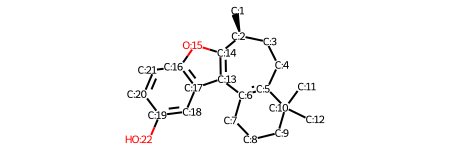

In [12]:
mol_with_atom_index(target)

In [16]:
changelogs = make_changelogs("./edit_files/edits_frondosin_danishefsky.csv")
changelogs[:3]

[{'edits': ()},
 {'pad': 0, 'pad_elem': [], 'edits': [(2, 2, 1)]},
 {'pad': 1, 'pad_elem': [6], 'edits': [(22, 23, 1)]}]

In [17]:
# check the changelogs here. usually the [1:] is because the first entry is blank.
out_1,final_atoms_1 = apply_changes(amat_init, target_atoms,changelogs[1:])

In [19]:
# adjusting, for when 2 concession atoms were added at once and should be bonded together
for i in out_1:
    amat_entry(i,33,34,1)

In [20]:
draw_mols = []
from rdkit.Chem.Draw import *
for i in range(len(out_1)):
    m = molFromAdjMat(final_atoms_1,out_1[i])
    Chem.SanitizeMol(m)
    draw_mols.append(m)
    print(Chem.MolToSmiles(m))

C.C.C.C=CN.CC(C)O.COC(=O)CCCC=CCO.COc1ccc(OC)cc1.I.O.[SiH4]
C.C.C.C=CN.CC(C)O.COC(=O)CCCC1OC1CO.COc1ccc(OC)cc1.I.[SiH4]
C.C.C=CN.CC(C)O.COC(=O)CCCC(C)C(O)CO.COc1ccc(OC)cc1.I.[SiH4]
C.C.C=CN.CC(C)O.CO.COC(=O)CCCC(C)C=O.COc1ccc(OC)cc1.I.[SiH4]
C.C#CC(C)CCCC(=O)OC.C=CN.CC(C)O.CO.COc1ccc(OC)cc1.I.O.[SiH4]
C.C#CC(C)CCCC(=O)OC.C=CN.CC(C)O.CO.COc1ccc(OC)c(I)c1.O.[SiH4]
C.C.C#CC(C)CCCC(=O)OC.C=CN.CC(C)O.CO.COc1ccc(O)c(I)c1.O.[SiH4]
C.C.C=CN.CC(C)O.CO.COC(=O)CCCC(C)C#Cc1cc(OC)ccc1O.I.O.[SiH4]
C.C.C=CN.CC(C)O.CO.COC(=O)CCCC(C)c1cc2cc(OC)ccc2o1.I.O.[SiH4]
C.C.C.C=CN.CC(C)O.CO.COc1ccc2oc(C(C)CCCC(=O)O)cc2c1.I.O.[SiH4]
C.C.C.C=CN.CC(C)O.CO.COc1ccc2oc3c(c2c1)C(=O)CCCC3C.I.O.O.[SiH4]
C.C.C.C=CN.CC(C)O.CO.COc1ccc2oc3c(c2c1)C(O[SiH3])=CCCC3C.I.O.O
C.C.C.C=CN.CO.COc1ccc2oc3c(c2c1)C(=O)C(C(C)(C)O)CCC3C.I.O.O.[SiH4]
C.C.C.C=CN.CO.COc1ccc2oc3c(c2c1)C(=O)C(=C(C)C)CCC3C.I.O.O.O.[SiH4]
C.C.C=C1C(=C(C)C)CCC(C)c2oc3ccc(OC)cc3c21.C=CN.CO.I.O.O.O.O.[SiH4]
C.C.CO.COc1ccc2oc3c(c2c1)C1=C(CCC3C)C(C)(C)C(N)CC1.I.O.O.O

In [21]:
save_dict = {"amats":out_1[:-1],"atoms":final_atoms_1}
np.savez("./matrices/frondosin_danishefsky",**save_dict)